In [39]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, GATConv, global_mean_pool, EdgeConv, TransformerConv
from torch_geometric.loader import DataLoader
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

## 1. Define Models

In [5]:
# --- 1. Define the GCN Model (with Batch Normalization and F.relu()) ---
class GCN(torch.nn.Module):
    # ... (GCN class implementation - same as in previous response) ...
    def __init__(self, num_node_features, hidden_channels, output_dim=1):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [46]:
# --- 2. Define the GIN Model (with Batch Normalization and F.relu()) ---
class GIN(torch.nn.Module):
    # ... (GIN class implementation - same as in previous response) ...
    def __init__(self, num_node_features, hidden_channels, output_dim=1):
        super(GIN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GINConv(
            Sequential(Linear(num_node_features, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU())
        )
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU())
        )
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU())
        )
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [7]:
# --- 3. Define the GAT Model (with Batch Normalization and F.relu()) ---
class GAT(torch.nn.Module):
    # ... (GAT class implementation - same as in previous response) ...
    def __init__(self, num_node_features, hidden_channels, heads=8, output_dim=1):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads)
        self.bn1 = BatchNorm1d(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.bn2 = BatchNorm1d(hidden_channels * heads)
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x


In [28]:
# --- 4. Define the EdgeConv Model (Corrected Linear Input Dimension) ---
class EdgeConvNet(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, output_dim=1):
        super(EdgeConvNet, self).__init__()
        torch.manual_seed(12345)
        # Corrected Linear Input Dimension to 2 * num_node_features
        self.conv1 = EdgeConv(Sequential(Linear(2 * num_node_features, hidden_channels), BatchNorm1d(hidden_channels), ReLU())) # Note: Input to Linear is now 2 * num_node_features
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = EdgeConv(Sequential(Linear(2 * hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU())) # Input is still 2 * hidden_channels in subsequent EdgeConvs
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = EdgeConv(Sequential(Linear(2 * hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU()))
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 3 EdgeConv layers with Batch Normalization
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [52]:
# --- 4. Define the Graph Transformer Model (using TransformerConv) ---
class GraphTransformerNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels, heads=8, output_dim=1): # Added attention heads
        super(GraphTransformerNet, self).__init__()
        torch.manual_seed(12345)
        # TransformerConv layers - now aware of edge features
        self.conv1 = TransformerConv(in_channels=num_node_features, out_channels=hidden_channels, heads=heads, edge_dim=num_edge_features) # Pass edge_dim
        self.bn1 = BatchNorm1d(hidden_channels * heads)
        self.conv2 = TransformerConv(in_channels=hidden_channels * heads, out_channels=hidden_channels, heads=heads, edge_dim=num_edge_features) # Pass edge_dim
        self.bn2 = BatchNorm1d(hidden_channels * heads)
        self.conv3 = TransformerConv(in_channels=hidden_channels * heads, out_channels=hidden_channels, heads=1, edge_dim=num_edge_features) # Pass edge_dim, output heads=1
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, output_dim)

    def forward(self, data):
        x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr # Edge features are used

        # 3 TransformerConv layers with Batch Normalization, now passing edge_attr
        x = self.conv1(x, edge_index, edge_attr) # Pass edge_attr to conv layers
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_attr) # Pass edge_attr to conv layers
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_attr) # Pass edge_attr to conv layers
        x = self.bn3(x)
        x = F.relu(x)

        # Graph-level readout (mean pooling)
        x = global_mean_pool(x, batch)

        # Final linear layer for regression
        x = self.lin(x)
        return x

## 2. Data Loading and Preparation 

In [9]:
import sys
if sys.platform.startswith(("linux", "darwin")):
    !mamba install -q -y -c pyg pyg

In [10]:
from torch_geometric.datasets import QM9
from pathlib import Path
# specify the local data path
HERE = Path("./data")
DATA = HERE
# load dataset
qm9 = QM9(root=DATA)

In [11]:
qm9[0]

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])

In [21]:
# --- 5. Data Loading and Preparation (Assuming QM9 dataset is loaded as 'qm9' as in your notebook) ---
# (This section is the same as before, no changes needed)
y_target = pd.DataFrame(qm9.data.y.numpy())
qm9.data.y = torch.Tensor(y_target[0]) # Use only the first column (Dipole Moment)

qm9 = qm9.shuffle() # Shuffle the dataset

data_size = len(qm9)
train_index = int(data_size * 0.8)
test_index = train_index + int(data_size * 0.1)
val_index = test_index + int(data_size * 0.1)

# --- Data Normalization ---
train_mean = qm9.data.y[0:train_index].mean() # Calculate mean on training set ONLY
train_std = qm9.data.y[0:train_index].std()   # Calculate std on training set ONLY

qm9.data.y = (qm9.data.y - train_mean) / train_std # Normalize entire target variable

train_loader = DataLoader(qm9[0:train_index], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[train_index:test_index], batch_size=64, shuffle=False) # No need to shuffle test/val
val_loader = DataLoader(qm9[test_index:val_index], batch_size=64, shuffle=False)

c:\Users\friha\.conda\envs\NetSci\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Users\friha\.conda\envs\NetSci\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `d

## 3. Define Training, Validation and Testing Functions

In [61]:
# --- 6. Training and Evaluation Functions (Same as before - no changes needed) ---
def train(model, optimizer, loader, loss_fn):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y.unsqueeze(1)) # Unsqueeze to match output shape
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    for data in loader:
        out = model(data)
        loss = loss_fn(out, data.y.unsqueeze(1)) # Unsqueeze to match output shape
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def testing(loader, model):
    """Testing function to evaluate model on a given dataloader.

    Args:
        loader (DataLoader): DataLoader for the test dataset.
        model (nn.Module): Trained GNN model.

    Returns:
        float: test loss
        numpy.ndarray: predicted target values
        numpy.ndarray: ground truth target values
    """
    loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss
    test_loss = 0
    test_target = np.empty((0))  # To store predictions
    test_y_target = np.empty((0)) # To store ground truth

    model.eval() # Set model to evaluation mode

    for data in loader:
        out = model(data) # Get model predictions
        loss = loss_fn(out, torch.reshape(data.y, (len(data.y), 1))) # Calculate loss
        test_loss += loss.item() / len(loader) # Accumulate loss

        # Save predictions vs ground truth values for plotting later
        test_target = np.concatenate((test_target, out.detach().numpy()[:, 0])) # Store predictions
        test_y_target = np.concatenate((test_y_target, data.y.detach().numpy())) # Store ground truth

    return test_loss, test_target, test_y_target

## 4. Training

In [40]:
# --- 7. Run Training and Evaluation for each model (Split into Cells) ---

model_types = {"GCN": GCN, "GIN": GIN, "GAT": GAT, "GraphTransformer": GraphTransformerNet} # Removed EdgeConv from model_types
results = {}

In [48]:
# --- 7.1. Training GCN Model ---
model_name = "GCN"
model_class = GCN

print(f"\n--- Training {model_name} Model ---")

hidden_channels = 64
model = model_class(num_node_features=qm9.num_node_features, hidden_channels=hidden_channels)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()
epochs = 20 # Reduced epochs to 10
train_losses_gcn = []
val_losses_gcn = []

start_time = time.time() # Start time for training

for epoch in tqdm(range(1, epochs + 1), desc=f"Training {model_name}"):
    epoch_start_time = time.time() # Epoch start time
    train_loss = train(model, optimizer, train_loader, loss_function)
    val_loss = evaluate(model, val_loader, loss_function)
    train_losses_gcn.append(train_loss)
    val_losses_gcn.append(val_loss)
    epoch_time = time.time() - epoch_start_time # Epoch training time

    if epoch % 2 == 0: # Print every 2 epochs instead of 10 for shorter training
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch Time: {epoch_time:.2f}s') # Print epoch time

test_loss_gcn = evaluate(model, test_loader, loss_function)
results["GCN"] = {"test_loss": test_loss_gcn, "train_losses": train_losses_gcn, "val_losses": val_losses_gcn}
total_training_time_gcn = time.time() - start_time # Total training time for GCN
print(f'\n{model_name} Test Loss: {test_loss_gcn:.4f}, Total Training Time: {total_training_time_gcn:.2f}s') # Print total training time

torch.save(model.state_dict(), f"{model_name}_model.pt")
print(f"Saved {model_name} model to: {model_name}_model.pt")


--- Training GCN Model ---


Training GCN:  10%|█         | 2/20 [01:00<09:03, 30.18s/it]

Epoch: 002, Train Loss: 0.7053, Val Loss: 0.6922, Epoch Time: 28.98s


Training GCN:  20%|██        | 4/20 [01:59<07:48, 29.30s/it]

Epoch: 004, Train Loss: 0.6643, Val Loss: 0.6710, Epoch Time: 27.92s


Training GCN:  30%|███       | 6/20 [03:00<07:02, 30.20s/it]

Epoch: 006, Train Loss: 0.6430, Val Loss: 0.6053, Epoch Time: 31.68s


Training GCN:  40%|████      | 8/20 [03:59<05:57, 29.82s/it]

Epoch: 008, Train Loss: 0.6230, Val Loss: 0.6448, Epoch Time: 29.35s


Training GCN:  50%|█████     | 10/20 [05:03<05:11, 31.12s/it]

Epoch: 010, Train Loss: 0.6031, Val Loss: 0.5666, Epoch Time: 34.19s


Training GCN:  60%|██████    | 12/20 [06:10<04:17, 32.21s/it]

Epoch: 012, Train Loss: 0.5992, Val Loss: 0.5548, Epoch Time: 30.35s


Training GCN:  70%|███████   | 14/20 [07:10<03:06, 31.00s/it]

Epoch: 014, Train Loss: 0.5839, Val Loss: 0.5697, Epoch Time: 29.27s


Training GCN:  80%|████████  | 16/20 [08:09<02:00, 30.07s/it]

Epoch: 016, Train Loss: 0.5799, Val Loss: 0.5425, Epoch Time: 29.07s


Training GCN:  90%|█████████ | 18/20 [09:10<01:00, 30.14s/it]

Epoch: 018, Train Loss: 0.5737, Val Loss: 0.5197, Epoch Time: 29.07s


Training GCN: 100%|██████████| 20/20 [10:11<00:00, 30.55s/it]

Epoch: 020, Train Loss: 0.5708, Val Loss: 0.5366, Epoch Time: 30.50s



GCN Test Loss: 0.5562, Total Training Time: 613.45s
Saved GCN model to: GCN_model.pt


In [49]:
# --- 7.2. Training GIN Model ---
model_name = "GIN"
model_class = GIN

print(f"\n--- Training {model_name} Model ---")

hidden_channels = 64
model = model_class(num_node_features=qm9.num_node_features, hidden_channels=hidden_channels)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()
epochs = 20 # Reduced epochs to 10
train_losses_gin = []
val_losses_gin = []

start_time = time.time() # Start time for training

for epoch in tqdm(range(1, epochs + 1), desc=f"Training {model_name}"):
    epoch_start_time = time.time() # Epoch start time
    train_loss = train(model, optimizer, train_loader, loss_function)
    val_loss = evaluate(model, val_loader, loss_function)
    train_losses_gin.append(train_loss)
    val_losses_gin.append(val_loss)
    epoch_time = time.time() - epoch_start_time # Epoch training time

    if epoch % 2 == 0: # Print every 2 epochs instead of 10 for shorter training
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch Time: {epoch_time:.2f}s') # Print epoch time

test_loss_gin = evaluate(model, test_loader, loss_function)
results["GIN"] = {"test_loss": test_loss_gin, "train_losses": train_losses_gin, "val_losses": val_losses_gin}
total_training_time_gin = time.time() - start_time # Total training time for GIN
print(f'\n{model_name} Test Loss: {test_loss_gin:.4f}, Total Training Time: {total_training_time_gin:.2f}s') # Print total training time

torch.save(model.state_dict(), f"{model_name}_model.pt")
print(f"Saved {model_name} model to: {model_name}_model.pt")


--- Training GIN Model ---


Training GIN:   0%|          | 0/20 [00:00<?, ?it/s]

Training GIN:  10%|█         | 2/20 [01:05<09:43, 32.44s/it]

Epoch: 002, Train Loss: 0.6192, Val Loss: 0.5405, Epoch Time: 30.74s


Training GIN:  20%|██        | 4/20 [02:07<08:20, 31.31s/it]

Epoch: 004, Train Loss: 0.5658, Val Loss: 0.8423, Epoch Time: 30.53s


Training GIN:  30%|███       | 6/20 [03:12<07:29, 32.12s/it]

Epoch: 006, Train Loss: 0.5423, Val Loss: 1.8495, Epoch Time: 32.54s


Training GIN:  40%|████      | 8/20 [04:18<06:29, 32.48s/it]

Epoch: 008, Train Loss: 0.5252, Val Loss: 0.6540, Epoch Time: 32.38s


Training GIN:  50%|█████     | 10/20 [05:22<05:22, 32.21s/it]

Epoch: 010, Train Loss: 0.5141, Val Loss: 0.6313, Epoch Time: 30.72s


Training GIN:  60%|██████    | 12/20 [06:27<04:17, 32.23s/it]

Epoch: 012, Train Loss: 0.5095, Val Loss: 1.3116, Epoch Time: 31.70s


Training GIN:  70%|███████   | 14/20 [07:29<03:10, 31.70s/it]

Epoch: 014, Train Loss: 0.4979, Val Loss: 22.0796, Epoch Time: 31.34s


Training GIN:  80%|████████  | 16/20 [08:34<02:07, 31.89s/it]

Epoch: 016, Train Loss: 0.4950, Val Loss: 3.9250, Epoch Time: 32.29s


Training GIN:  90%|█████████ | 18/20 [09:37<01:03, 31.87s/it]

Epoch: 018, Train Loss: 0.4905, Val Loss: 0.4675, Epoch Time: 32.21s


Training GIN: 100%|██████████| 20/20 [10:39<00:00, 31.97s/it]

Epoch: 020, Train Loss: 0.4843, Val Loss: 0.9435, Epoch Time: 31.25s



GIN Test Loss: 2.3858, Total Training Time: 641.58s
Saved GIN model to: GIN_model.pt


In [53]:
# --- 7.3. Training GAT Model ---
model_name = "GAT"
model_class = GAT

print(f"\n--- Training {model_name} Model ---")

hidden_channels = 64
model = model_class(num_node_features=qm9.num_node_features, hidden_channels=hidden_channels, heads=8)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()
epochs = 20 # Reduced epochs to 10
train_losses_gat = []
val_losses_gat = []

start_time = time.time() # Start time for training

for epoch in tqdm(range(1, epochs + 1), desc=f"Training {model_name}"):
    epoch_start_time = time.time() # Epoch start time
    train_loss = train(model, optimizer, train_loader, loss_function)
    val_loss = evaluate(model, val_loader, loss_function)
    train_losses_gat.append(train_loss)
    val_losses_gat.append(val_loss)
    epoch_time = time.time() - epoch_start_time # Epoch training time

    if epoch % 2 == 0: # Print every 2 epochs instead of 10 for shorter training
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch Time: {epoch_time:.2f}s') # Print epoch time

test_loss_gat = evaluate(model, test_loader, loss_function)
results["GAT"] = {"test_loss": test_loss_gat, "train_losses": train_losses_gat, "val_losses": val_losses_gat}
total_training_time_gat = time.time() - start_time # Total training time for GAT
print(f'\n{model_name} Test Loss: {test_loss_gat:.4f}, Total Training Time: {total_training_time_gat:.2f}s') # Print total training time

torch.save(model.state_dict(), f"{model_name}_model.pt")
print(f"Saved {model_name} model to: {model_name}_model.pt")


--- Training GAT Model ---


Training GAT:  10%|█         | 2/20 [03:54<34:47, 115.96s/it]

Epoch: 002, Train Loss: 0.5968, Val Loss: 0.5317, Epoch Time: 109.12s


Training GAT:  20%|██        | 4/20 [07:28<29:12, 109.50s/it]

Epoch: 004, Train Loss: 0.5555, Val Loss: 0.5209, Epoch Time: 104.69s


Training GAT:  30%|███       | 6/20 [11:03<25:20, 108.58s/it]

Epoch: 006, Train Loss: 0.5285, Val Loss: 0.4836, Epoch Time: 109.93s


Training GAT:  40%|████      | 8/20 [15:24<24:02, 120.21s/it]

Epoch: 008, Train Loss: 0.5163, Val Loss: 0.4655, Epoch Time: 126.83s


Training GAT:  50%|█████     | 10/20 [19:09<19:21, 116.16s/it]

Epoch: 010, Train Loss: 0.5026, Val Loss: 0.4568, Epoch Time: 112.36s


Training GAT:  60%|██████    | 12/20 [22:54<15:14, 114.26s/it]

Epoch: 012, Train Loss: 0.4952, Val Loss: 0.4597, Epoch Time: 113.21s


Training GAT:  70%|███████   | 14/20 [26:42<11:23, 113.87s/it]

Epoch: 014, Train Loss: 0.4886, Val Loss: 0.4458, Epoch Time: 112.02s


Training GAT:  80%|████████  | 16/20 [30:26<07:30, 112.51s/it]

Epoch: 016, Train Loss: 0.4818, Val Loss: 0.4471, Epoch Time: 107.02s


Training GAT:  90%|█████████ | 18/20 [33:58<03:38, 109.27s/it]

Epoch: 018, Train Loss: 0.4759, Val Loss: 0.4431, Epoch Time: 106.27s


Training GAT: 100%|██████████| 20/20 [37:28<00:00, 112.42s/it]

Epoch: 020, Train Loss: 0.4750, Val Loss: 0.4512, Epoch Time: 104.70s



GAT Test Loss: 0.4638, Total Training Time: 2254.41s
Saved GAT model to: GAT_model.pt


In [54]:
# --- 7.4. Training GraphTransformer Model ---
model_name = "GraphTransformer"
model_class = GraphTransformerNet

print(f"\n--- Training {model_name} Model ---")

hidden_channels = 64
model = model_class(num_node_features=qm9.num_node_features, num_edge_features=qm9.num_edge_features, hidden_channels=hidden_channels, heads=4) # GraphTransformer Model, heads=4

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()
epochs = 20 # Reduced epochs to 10
train_losses_graph_transformer = []
val_losses_graph_transformer = []

start_time = time.time() # Start time for training

for epoch in tqdm(range(1, epochs + 1), desc=f"Training {model_name}"):
    epoch_start_time = time.time() # Epoch start time
    train_loss = train(model, optimizer, train_loader, loss_function)
    val_loss = evaluate(model, val_loader, loss_function)
    train_losses_graph_transformer.append(train_loss)
    val_losses_graph_transformer.append(val_loss)
    epoch_time = time.time() - epoch_start_time # Epoch training time

    if epoch % 2 == 0: # Print every 2 epochs instead of 10 for shorter training
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch Time: {epoch_time:.2f}s') # Print epoch time

test_loss_graph_transformer = evaluate(model, test_loader, loss_function)
results["GraphTransformer"] = {"test_loss": test_loss_graph_transformer, "train_losses": train_losses_graph_transformer, "val_losses": val_losses_graph_transformer} # Store results for GraphTransformer
total_training_time_graph_transformer = time.time() - start_time # Total training time for GraphTransformer
print(f'\n{model_name} Test Loss: {test_loss_graph_transformer:.4f}, Total Training Time: {total_training_time_graph_transformer:.2f}s') # Print total training time

torch.save(model.state_dict(), f"{model_name}_model.pt")
print(f"Saved {model_name} model to: {model_name}_model.pt")


--- Training GraphTransformer Model ---


Training GraphTransformer:  10%|█         | 2/20 [03:09<28:34, 95.24s/it]

Epoch: 002, Train Loss: 0.5408, Val Loss: 0.4495, Epoch Time: 96.81s


Training GraphTransformer:  20%|██        | 4/20 [06:36<26:54, 100.91s/it]

Epoch: 004, Train Loss: 0.4722, Val Loss: 0.4019, Epoch Time: 105.88s


Training GraphTransformer:  30%|███       | 6/20 [10:16<24:49, 106.39s/it]

Epoch: 006, Train Loss: 0.4487, Val Loss: 0.3760, Epoch Time: 112.35s


Training GraphTransformer:  40%|████      | 8/20 [14:01<21:56, 109.70s/it]

Epoch: 008, Train Loss: 0.4343, Val Loss: 0.3824, Epoch Time: 112.63s


Training GraphTransformer:  50%|█████     | 10/20 [18:18<19:57, 119.73s/it]

Epoch: 010, Train Loss: 0.4256, Val Loss: 0.3702, Epoch Time: 130.57s


Training GraphTransformer:  60%|██████    | 12/20 [22:40<16:46, 125.81s/it]

Epoch: 012, Train Loss: 0.4195, Val Loss: 0.3704, Epoch Time: 133.00s


Training GraphTransformer:  70%|███████   | 14/20 [27:06<12:58, 129.70s/it]

Epoch: 014, Train Loss: 0.4158, Val Loss: 0.3601, Epoch Time: 133.86s


Training GraphTransformer:  80%|████████  | 16/20 [31:32<08:44, 131.24s/it]

Epoch: 016, Train Loss: 0.4068, Val Loss: 0.3516, Epoch Time: 132.51s


Training GraphTransformer:  90%|█████████ | 18/20 [35:59<04:24, 132.34s/it]

Epoch: 018, Train Loss: 0.4049, Val Loss: 0.3517, Epoch Time: 132.01s


Training GraphTransformer: 100%|██████████| 20/20 [40:24<00:00, 121.22s/it]

Epoch: 020, Train Loss: 0.3952, Val Loss: 0.3366, Epoch Time: 132.15s



GraphTransformer Test Loss: 0.3411, Total Training Time: 2429.48s
Saved GraphTransformer model to: GraphTransformer_model.pt


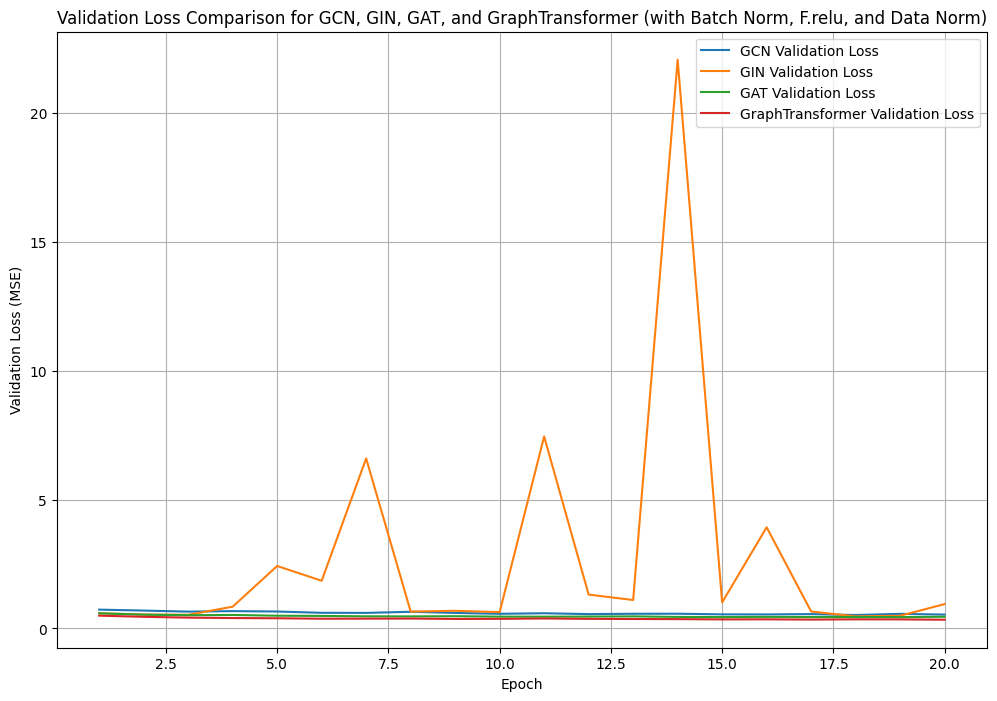

GCN Test Loss: 0.5562
GIN Test Loss: 2.3858
GAT Test Loss: 0.4638
GraphTransformer Test Loss: 0.3411


In [55]:
# --- 8. Compare and Plot Results ---
# (Section 8 code remains the same)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for model_name, result in results.items():
    plt.plot(range(1, epochs + 1), result["val_losses"], label=f'{model_name} Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.title('Validation Loss Comparison for GCN, GIN, GAT, and GraphTransformer (with Batch Norm, F.relu, and Data Norm)') # Updated title - EdgeConv removed
plt.legend()
plt.grid(True)
plt.show()


for model_name, result in results.items():
    print(f"{model_name} Test Loss: {result['test_loss']:.4f}")

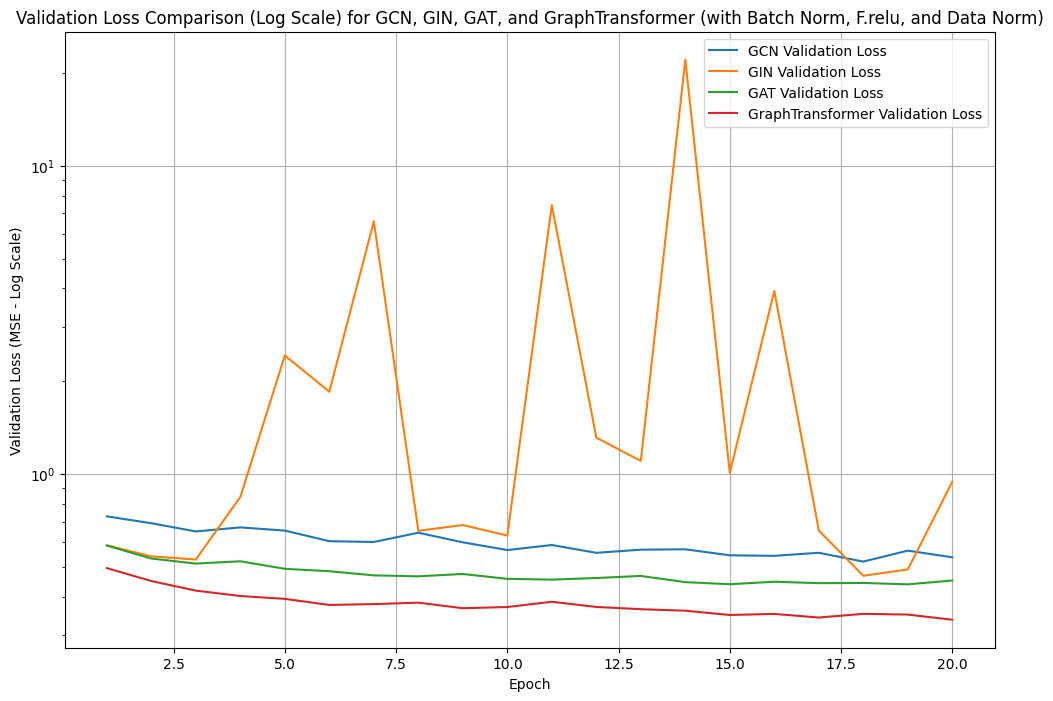

GCN Test Loss: 0.5562
GIN Test Loss: 2.3858
GAT Test Loss: 0.4638
GraphTransformer Test Loss: 0.3411


In [56]:
# --- 8. Compare and Plot Results ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for model_name, result in results.items():
    plt.plot(range(1, epochs + 1), result["val_losses"], label=f'{model_name} Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE - Log Scale)') # Updated y-axis label
plt.title('Validation Loss Comparison (Log Scale) for GCN, GIN, GAT, and GraphTransformer (with Batch Norm, F.relu, and Data Norm)') # Updated title
plt.yscale('log') # Set y-axis to logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


for model_name, result in results.items():
    print(f"{model_name} Test Loss: {result['test_loss']:.4f}")

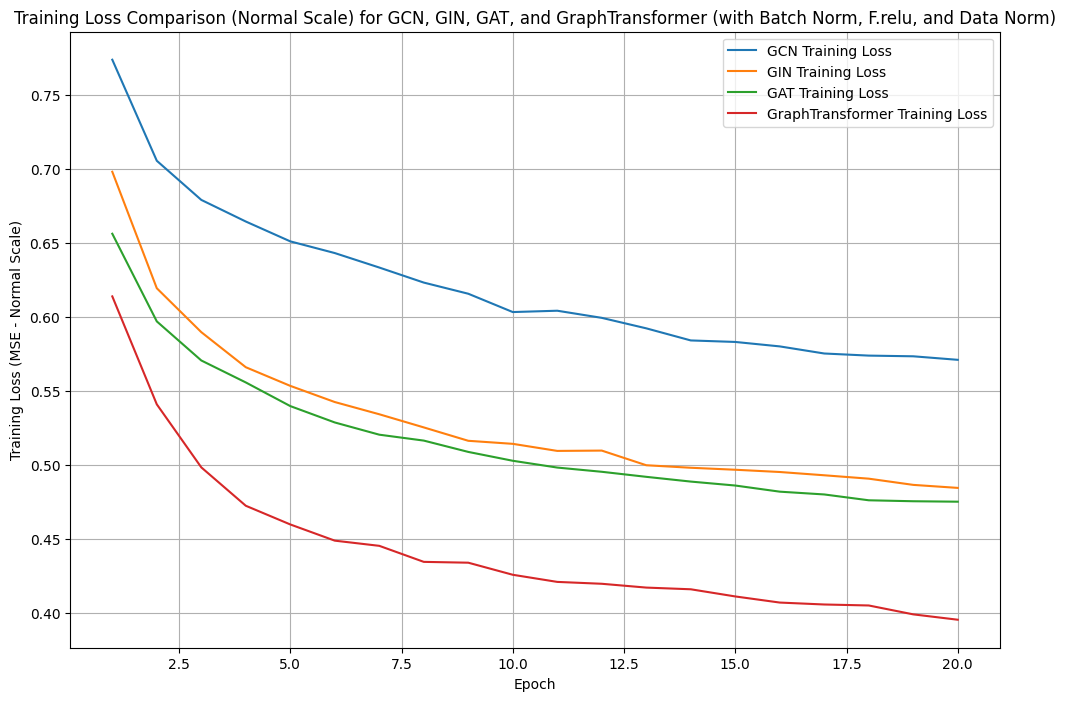

GCN Test Loss: 0.5562
GIN Test Loss: 2.3858
GAT Test Loss: 0.4638
GraphTransformer Test Loss: 0.3411


In [59]:
plt.figure(figsize=(12, 8))
for model_name, result in results.items():
    plt.plot(range(1, epochs + 1), result["train_losses"], label=f'{model_name} Training Loss') # Plot train_losses instead of val_losses

plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE - Normal Scale)') # Updated y-axis label to indicate normal scale
plt.title('Training Loss Comparison (Normal Scale) for GCN, GIN, GAT, and GraphTransformer (with Batch Norm, F.relu, and Data Norm)') # Updated title
# plt.yscale('log') # Removed log scale - using normal scale now
plt.legend()
plt.grid(True)
plt.show()


for model_name, result in results.items():
    print(f"{model_name} Test Loss: {result['test_loss']:.4f}")


--- Re-testing GCN Model ---


C:\Users\friha\AppData\Local\Temp\ipykernel_13248\2222375930.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)) # Load saved 

GCN Re-test Loss: 0.5562

--- Re-testing GIN Model ---
GIN Re-test Loss: 2.3858

--- Re-testing GAT Model ---
GAT Re-test Loss: 0.4638

--- Re-testing GraphTransformer Model ---
GraphTransformer Re-test Loss: 0.3411


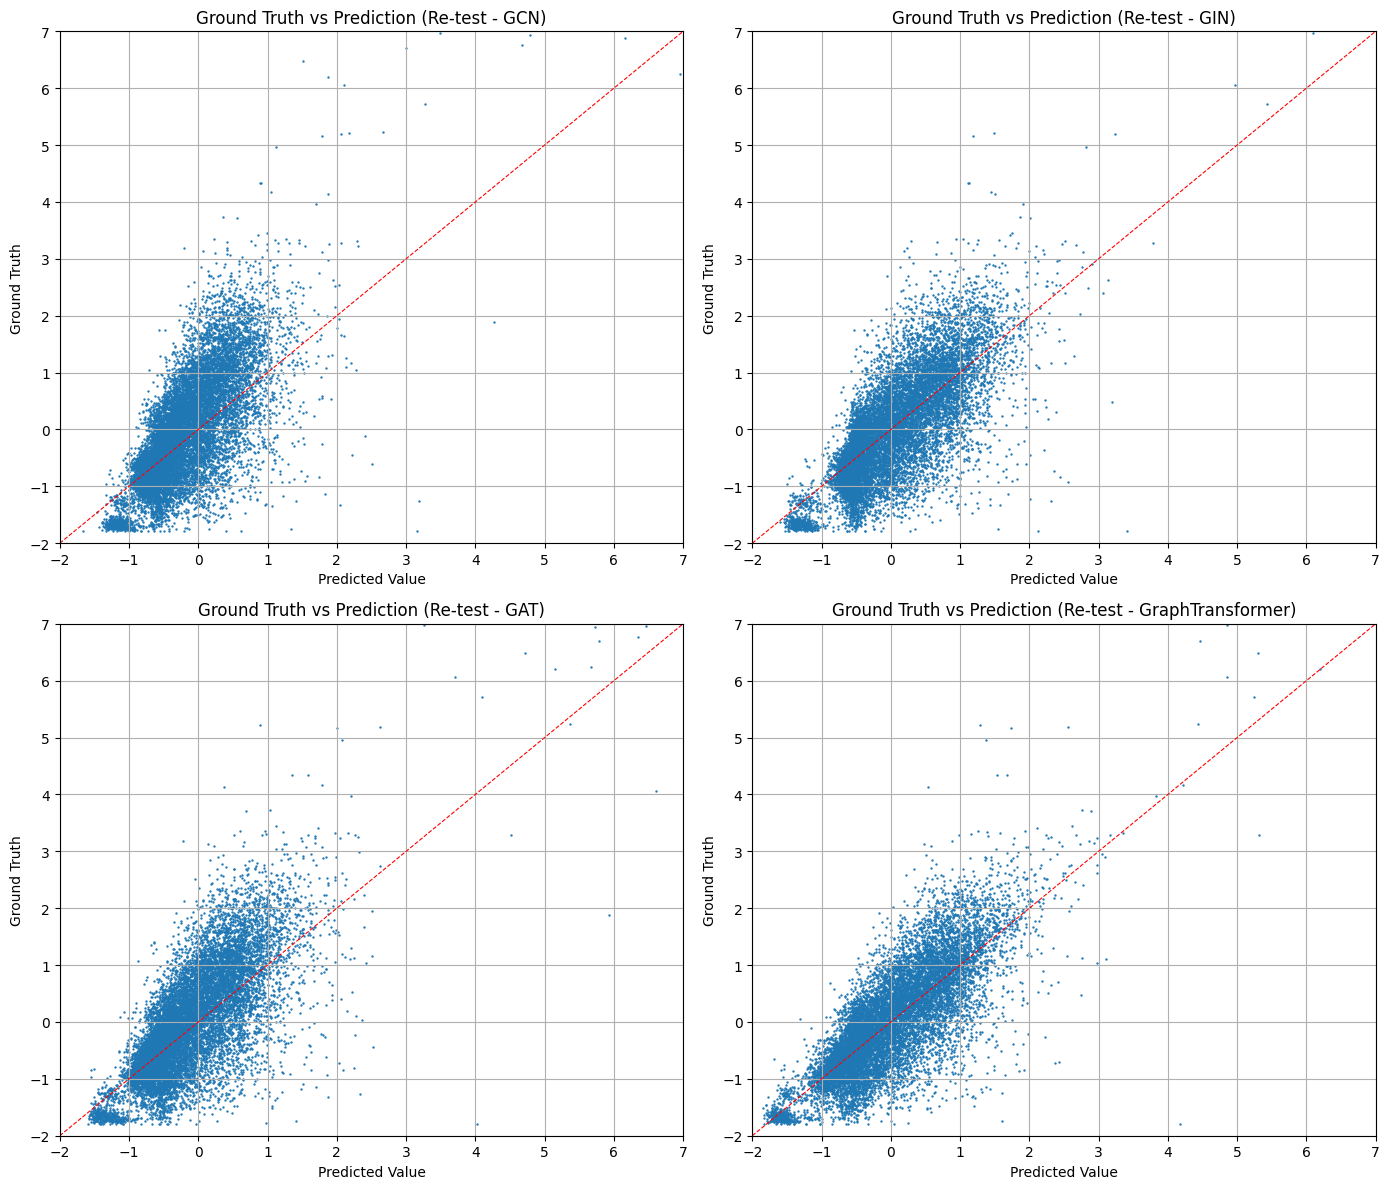

GCN Re-test Loss: 0.5562
GIN Re-test Loss: 2.3858
GAT Re-test Loss: 0.4638
GraphTransformer Re-test Loss: 0.3411


In [63]:
# --- 9. Re-testing All Models (Loading Saved Models and Evaluating) ---

model_types = {"GCN": GCN, "GIN": GIN, "GAT": GAT, "GraphTransformer": GraphTransformerNet} # Model types dictionary

retest_results = {} # Dictionary to store re-test results

for model_name, model_class in model_types.items():
    print(f"\n--- Re-testing {model_name} Model ---")

    hidden_channels = 64 # Common hidden channel size - ensure it matches your training
    heads = 8 if model_name == "GAT" else 4 if model_name == "GraphTransformer" else None # Heads for GAT and GraphTransformer

    # Initialize model architecture (same as during training)
    if model_name == "GAT":
        model = model_class(num_node_features=qm9.num_node_features, hidden_channels=hidden_channels, heads=heads)
    elif model_name == "GraphTransformer":
        model = model_class(num_node_features=qm9.num_node_features, num_edge_features=qm9.num_edge_features, hidden_channels=hidden_channels, heads=heads)
    else:
        model = model_class(num_node_features=qm9.num_node_features, hidden_channels=hidden_channels)


    # Load saved model weights
    model_path = f"{model_name}_model.pt"
    model.load_state_dict(torch.load(model_path)) # Load saved state_dict
    model.eval() # Set model to evaluation mode

    # Evaluate on test set
    test_loss, test_target, test_y_target = testing(test_loader, model) # Use testing function

    retest_results[model_name] = {"test_loss": test_loss, "test_target": test_target, "test_y_target": test_y_target} # Store re-test results

    print(f'{model_name} Re-test Loss: {test_loss:.4f}') # Print re-test loss


# --- 10. (Optional) Re-plot Ground Truth vs Prediction (using re-tested models) ---
import matplotlib.pyplot as plt

# Create a figure and a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

model_names = ["GCN", "GIN", "GAT", "GraphTransformer"]

for i, model_name in enumerate(model_names):
    result = retest_results[model_name] # Use retest_results now
    test_target = result["test_target"]
    test_y_target = result["test_y_target"]
    ax = axes[i]

    ax.scatter(test_target, test_y_target, s=0.5)
    ax.plot([-2, 7], [-2, 7], color='red', linestyle='--', linewidth=0.8)

    ax.set_title(f'Ground Truth vs Prediction (Re-test - {model_name})') # Updated title for re-test
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('Ground Truth')
    ax.set_xlim([-2, 7])
    ax.set_ylim([-2, 7])
    ax.grid(True)

plt.tight_layout()
plt.show()

for model_name, result in retest_results.items(): # Print re-test losses
    print(f"{model_name} Re-test Loss: {result['test_loss']:.4f}")